In [55]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy import integrate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support,make_scorer
from sklearn.metrics import confusion_matrix

In [56]:
DATA_PATH = '../data/features/'

tran = pd.read_csv(DATA_PATH + "T.csv")
tran = tran.set_index(['ID', 'copy_num'])

ntran = pd.read_csv(DATA_PATH + "NT.csv")
ntran = ntran.set_index(['ID', 'copy_num'])


In [57]:
ntran.chi2sGauss.unique()

array([5.35053736e+05, 3.50093712e+06, 1.71295886e+10, ...,
       1.16784575e+06, 4.41703118e+05, 2.58099522e+05])

In [58]:
print("Total amout of obects (oversampled):     {}".format(tran.shape[0]+ntran.shape[0]))
print("Total amout of obects (not oversampled): {}".format(tran[tran.index.get_level_values("copy_num")==0].shape[0]+ntran.shape[0]))

Total amout of obects (oversampled):     62152
Total amout of obects (not oversampled): 19462


In [59]:
feats = np.array(tran.columns[:-2])
print("Total number of features: {}".format(len(feats)))
print()
print("The features are:")
for i,f in enumerate(feats):
    print("    "+str(i+1)+". " + f)


Total number of features: 32

The features are:
    1. skew
    2. std
    3. kurtosis
    4. beyond1st
    5. stetson_j
    6. stetson_k
    7. max_slope
    8. amplitude
    9. median_absolute_deviation
    10. median_buffer_range_percentage
    11. pair_slope_trend
    12. percent_amplitude
    13. percent_difference_flux_percentile
    14. flux_percentile_ratio_mid20
    15. flux_percentile_ratio_mid35
    16. flux_percentile_ratio_mid50
    17. flux_percentile_ratio_mid65
    18. flux_percentile_ratio_mid80
    19. small_kurtosis
    20. pair_slope_trend_last_30
    21. poly1_t1
    22. poly2_t2
    23. poly2_t1
    24. poly3_t3
    25. poly3_t2
    26. poly3_t1
    27. poly4_t4
    28. poly4_t3
    29. poly4_t2
    30. poly4_t1
    31. chi2SALT2
    32. chi2sGauss


In [60]:
alldf = pd.concat([tran,ntran])

# Binary Classification 
Transients and non-transients 

In [61]:
def splitTrainTest(dataframe):
    #create output dataframes
    test = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    test = test.set_index(["ID","copy_num"])

    train = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    train = train.set_index(["ID","copy_num"])
    
    for uClass in dataframe.Class.unique():
        #get each class 
        classDf = dataframe[dataframe.Class == uClass]
        
        #unique ids
        ids = classDf.index.get_level_values('ID').unique()

        # randomly choose 25% of indices 

        testInd = np.random.choice(ids, int(0.25*len(ids)),replace=False)

        #get dataframes
        test = pd.concat([test,classDf[classDf.index.get_level_values('ID').isin(testInd)]])
        
        train = pd.concat([train,classDf[~classDf.index.get_level_values('ID').isin(testInd)]])

    return train,test


In [62]:
def balance(df):
    #start min at infinity 
    minNum = np.inf
    
    #find the class with the minimum amount of candidates
    for classElem in df.Class.unique():
        numElems = len(df[df.Class==classElem])
        if(numElems<minNum):
            minNum=numElems
    
    #create output dataframe
    ans = pd.DataFrame(columns = ["ID","copy_num"]+list(df.columns))
    ans = ans.set_index(["ID","copy_num"])
    
    #get a sample from all the classes 
    for classElem in df.Class.unique():
        ans = pd.concat([ans,df[df.Class==classElem].sample(n=minNum)])
        
    return ans

In [63]:
#hypermarameters that gridsearch will optimize
def rf():
    params = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    return RandomForestClassifier(random_state=0, class_weight='balanced'), params

#metrics to be analized
def scorers():
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')
               }
    return scoring

In [71]:
#copy and shuffle the data
oversampling = alldf.copy()
oversampling = oversampling.sample(frac=1)

#map all objects that are not non-transient to transient
oversampling.Class = list(map(lambda x: 'SN' if x=='SN' else 'NSN', oversampling.Class))
#map transient and non-transient to binary values
oversampling['target'] = list(map(lambda x: 1 if x=='SN' else 0, oversampling.Class))

In [72]:
recall_scores = []

    
#split train test class by class
all_train,all_test = splitTrainTest(oversampling)

#balance the train set
all_train= balance(all_train)

#train indices
trainIdx = all_train.index.get_level_values("ID").unique()

#remove originals that have oversampled copies in train
all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]

#remove oversampled data from test set
all_test = all_test[all_test.index.get_level_values('copy_num') ==0 ]


#format target variable to appropriate data type
all_train.target= all_train.target.astype('int')
all_test.target= all_test.target.astype('int')

print("SN in test set:")
print(len(all_test[all_test.Class=='SN']))
print("NSN in test set:")
print(len(all_test[all_test.Class!='SN']))

#learning 
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(all_train[feats], all_train.target)

# Copy classifier 
clf = grid_search

#see performance on test set
scores = precision_recall_fscore_support(
        all_test.target, clf.predict(all_test[feats]), average='weighted')
recall_scores.append(scores)

In [75]:
recall_scoresnp = np.array(recall_scores)

print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))

Precision: 0.9362
Recall:    0.9001
F-score:   0.9139


In [76]:
#calculate feature importance in descending order
importances = clf.best_estimator_.feature_importances_*100
featsCopy = feats.copy()
print(featsCopy)
Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))
yx.sort()

yx = yx[::-1]

x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]
print(x_sorted)

['skew' 'std' 'kurtosis' 'beyond1st' 'stetson_j' 'stetson_k' 'max_slope'
 'amplitude' 'median_absolute_deviation' 'median_buffer_range_percentage'
 'pair_slope_trend' 'percent_amplitude'
 'percent_difference_flux_percentile' 'flux_percentile_ratio_mid20'
 'flux_percentile_ratio_mid35' 'flux_percentile_ratio_mid50'
 'flux_percentile_ratio_mid65' 'flux_percentile_ratio_mid80'
 'small_kurtosis' 'pair_slope_trend_last_30' 'poly1_t1' 'poly2_t2'
 'poly2_t1' 'poly3_t3' 'poly3_t2' 'poly3_t1' 'poly4_t4' 'poly4_t3'
 'poly4_t2' 'poly4_t1' 'chi2SALT2' 'chi2sGauss']
['chi2sGauss', 'small_kurtosis', 'poly2_t1', 'std', 'median_absolute_deviation', 'stetson_j', 'poly1_t1', 'poly3_t1', 'poly4_t1', 'amplitude', 'percent_amplitude', 'percent_difference_flux_percentile', 'stetson_k', 'skew', 'max_slope', 'pair_slope_trend_last_30', 'median_buffer_range_percentage', 'poly4_t2', 'kurtosis', 'poly3_t2', 'flux_percentile_ratio_mid65', 'poly2_t2', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid35', '

In [77]:
 def shorten(x):
    return {
      'stetson_j':'stetson_j',
      'std':'std',
      'median_absolute_deviation':'mad',
      'amplitude':'amp',
      'poly1_t1':'poly2_t1',
      'poly2_t1':'poly1_t1',
      'skew':'skew',
      'poly3_t1':'poly3_t1',
      'small_kurtosis':'sk',
      'stetson_k':'stetson_k',
      'median_buffer_range_percentage':'mbrp',
      'percent_amplitude': 'p_amp',
      'percent_difference_flux_percentile':'pdfp',
      'poly4_t1':'poly4_t1',
      'poly3_t2':'poly3_t2',
      'poly4_t2':'poly4_t2',
      'max_slope':'max_slope',
      'kurtosis':'kurtosis',
      'pair_slope_trend':'pst',
      'poly2_t2':'poly2_t2',
      'beyond1st':'beyond1st',
      'flux_percentile_ratio_mid35':'fpr35',
      'flux_percentile_ratio_mid50':'fpr50',
      'flux_percentile_ratio_mid65':'fpr65',
      'flux_percentile_ratio_mid20':'fpr20',
      'flux_percentile_ratio_mid80':'fpr80',
      'pair_slope_trend_last_30':'pst_last30',
      'poly3_t3':'poly3_t3',
      'poly4_t3':'poly4_t3',
      'poly4_t4':'poly4_t4', 
      'chi2sGauss':'chi2sGauss',
      'chi2SALT2':'chi2SALT2'
      }[x]

In [78]:
#shorten name length
for i,x in enumerate(x_sorted):
    x_sorted[i]=shorten(x)

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


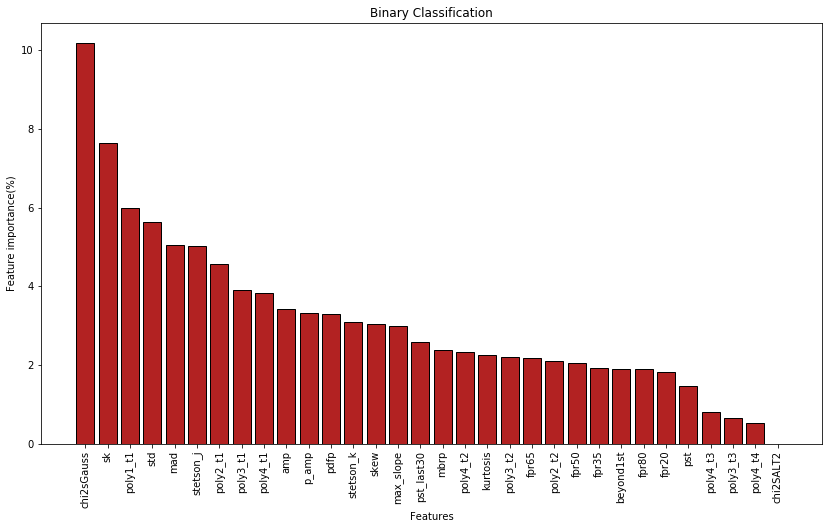

In [79]:


plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='firebrick')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("Binary Classification")
plt.savefig("../results/binFeatImportance.pdf")

In [80]:
cm = confusion_matrix(all_test.target, clf.predict(all_test[feats])).transpose()
cm

array([[4155,   99],
       [ 387,  224]])

In [81]:
all_test.target.sum()

323

In [82]:
def fMeasure(precision,recall):
    return 2*precision*recall/(precision+recall)

In [83]:
precisionNon = cm[0][0]/(cm[0][0]+cm[0][1])
recallNon = cm[0][0]/(cm[0][0]+cm[1][0])
precisionT = cm[1][1]/(cm[1][1]+cm[1][0])
recallT = cm[1][1]/(cm[1][1]+cm[0][1])

In [85]:
print("Precision of SN:     {:.4f}".format(precisionT))
print("Recall of SN:        {:.4f}".format(recallT))
print("F-measure of SN:     {:.4f}".format(fMeasure(precisionT,recallT)))
print("Precision of NSN: {:.4f}".format(precisionNon))
print("Recall of NSN:    {:.4f}".format(recallNon))
print("F-measure of NSN: {:.4f}".format(fMeasure(precisionNon,recallNon)))


Precision of SN:     0.3666
Recall of SN:        0.6935
F-measure of SN:     0.4797
Precision of NSN: 0.9767
Recall of NSN:    0.9148
F-measure of NSN: 0.9447


# Without using chi2s

In [87]:
feats = feats[:-2]

In [89]:
feats

array(['skew', 'std', 'kurtosis', 'beyond1st', 'stetson_j', 'stetson_k',
       'max_slope', 'amplitude', 'median_absolute_deviation',
       'median_buffer_range_percentage', 'pair_slope_trend',
       'percent_amplitude', 'percent_difference_flux_percentile',
       'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35',
       'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65',
       'flux_percentile_ratio_mid80', 'small_kurtosis',
       'pair_slope_trend_last_30', 'poly1_t1', 'poly2_t2', 'poly2_t1',
       'poly3_t3', 'poly3_t2', 'poly3_t1', 'poly4_t4', 'poly4_t3',
       'poly4_t2', 'poly4_t1'], dtype=object)

In [90]:
recall_scores = []

    
#split train test class by class
all_train,all_test = splitTrainTest(oversampling)

#balance the train set
all_train= balance(all_train)

#train indices
trainIdx = all_train.index.get_level_values("ID").unique()

#remove originals that have oversampled copies in train
all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]

#remove oversampled data from test set
all_test = all_test[all_test.index.get_level_values('copy_num') ==0 ]


#format target variable to appropriate data type
all_train.target= all_train.target.astype('int')
all_test.target= all_test.target.astype('int')

print("SN in test set:")
print(len(all_test[all_test.Class=='SN']))
print("NSN in test set:")
print(len(all_test[all_test.Class!='SN']))

#learning 
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(all_train[feats], all_train.target)

# Copy classifier 
clf = grid_search

#see performance on test set
scores = precision_recall_fscore_support(
        all_test.target, clf.predict(all_test[feats]), average='weighted')
recall_scores.append(scores)

SN in test set:
323
NSN in test set:
4542
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8748828491096532, precision=0.8767045616627591, recall=0.8748828491096532, f1_score=0.8747314019274028, total=   8.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8676663542642924, precision=0.8684754869985538, recall=0.8676663542642924, f1_score=0.8675936667299431, total=   8.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.0s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.8721649484536083, precision=0.8742477914907673, recall=0.8721649484536083, f1_score=0.8719868369648068, total=  28.6s
[Parallel

In [91]:
recall_scoresnp = np.array(recall_scores)

print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))

Precision: 0.9341
Recall:    0.8970
F-score:   0.9113


In [92]:
#calculate feature importance in descending order
importances = clf.best_estimator_.feature_importances_*100
featsCopy = feats.copy()
print(featsCopy)
Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))
yx.sort()

yx = yx[::-1]

x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]
print(x_sorted)

['skew' 'std' 'kurtosis' 'beyond1st' 'stetson_j' 'stetson_k' 'max_slope'
 'amplitude' 'median_absolute_deviation' 'median_buffer_range_percentage'
 'pair_slope_trend' 'percent_amplitude'
 'percent_difference_flux_percentile' 'flux_percentile_ratio_mid20'
 'flux_percentile_ratio_mid35' 'flux_percentile_ratio_mid50'
 'flux_percentile_ratio_mid65' 'flux_percentile_ratio_mid80'
 'small_kurtosis' 'pair_slope_trend_last_30' 'poly1_t1' 'poly2_t2'
 'poly2_t1' 'poly3_t3' 'poly3_t2' 'poly3_t1' 'poly4_t4' 'poly4_t3'
 'poly4_t2' 'poly4_t1']
['small_kurtosis', 'poly2_t1', 'std', 'stetson_j', 'median_absolute_deviation', 'poly1_t1', 'amplitude', 'poly3_t1', 'poly4_t1', 'percent_amplitude', 'percent_difference_flux_percentile', 'max_slope', 'skew', 'stetson_k', 'median_buffer_range_percentage', 'pair_slope_trend_last_30', 'poly3_t2', 'poly4_t2', 'kurtosis', 'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid50', 'poly2_t2', 'beyond1st', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid8

In [93]:
 def shorten(x):
    return {
      'stetson_j':'stetson_j',
      'std':'std',
      'median_absolute_deviation':'mad',
      'amplitude':'amp',
      'poly1_t1':'poly2_t1',
      'poly2_t1':'poly1_t1',
      'skew':'skew',
      'poly3_t1':'poly3_t1',
      'small_kurtosis':'sk',
      'stetson_k':'stetson_k',
      'median_buffer_range_percentage':'mbrp',
      'percent_amplitude': 'p_amp',
      'percent_difference_flux_percentile':'pdfp',
      'poly4_t1':'poly4_t1',
      'poly3_t2':'poly3_t2',
      'poly4_t2':'poly4_t2',
      'max_slope':'max_slope',
      'kurtosis':'kurtosis',
      'pair_slope_trend':'pst',
      'poly2_t2':'poly2_t2',
      'beyond1st':'beyond1st',
      'flux_percentile_ratio_mid35':'fpr35',
      'flux_percentile_ratio_mid50':'fpr50',
      'flux_percentile_ratio_mid65':'fpr65',
      'flux_percentile_ratio_mid20':'fpr20',
      'flux_percentile_ratio_mid80':'fpr80',
      'pair_slope_trend_last_30':'pst_last30',
      'poly3_t3':'poly3_t3',
      'poly4_t3':'poly4_t3',
      'poly4_t4':'poly4_t4', 
      'chi2sGauss':'chi2sGauss',
      'chi2SALT2':'chi2SALT2'
      }[x]

In [94]:
#shorten name length
for i,x in enumerate(x_sorted):
    x_sorted[i]=shorten(x)

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


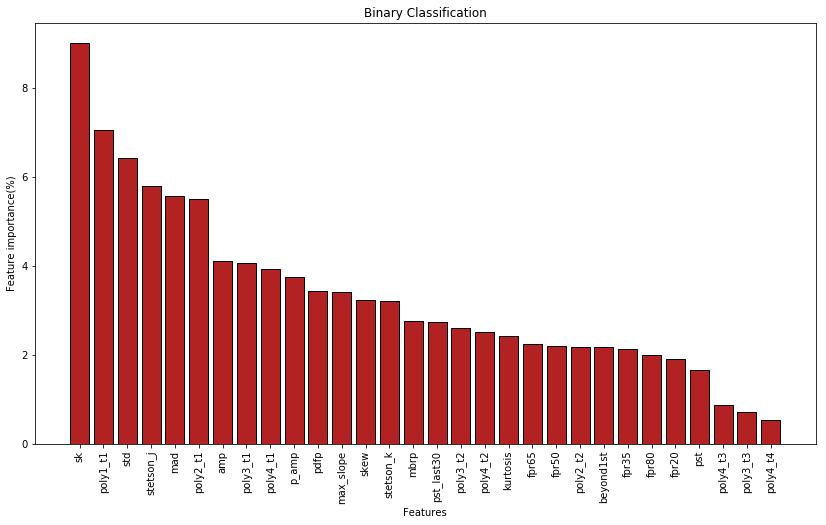

In [95]:


plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='firebrick')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("Binary Classification")
plt.savefig("../results/binFeatImportance.pdf")

In [102]:
cm = confusion_matrix(all_test.target, clf.predict(all_test[feats])).transpose()
cm

array([[4146,  105],
       [ 396,  218]])

In [97]:
all_test.target.sum()

323

In [98]:
def fMeasure(precision,recall):
    return 2*precision*recall/(precision+recall)

In [99]:
precisionNon = cm[0][0]/(cm[0][0]+cm[0][1])
recallNon = cm[0][0]/(cm[0][0]+cm[1][0])
precisionT = cm[1][1]/(cm[1][1]+cm[1][0])
recallT = cm[1][1]/(cm[1][1]+cm[0][1])

In [100]:
print("Precision of SN:     {:.4f}".format(precisionT))
print("Recall of SN:        {:.4f}".format(recallT))
print("F-measure of SN:     {:.4f}".format(fMeasure(precisionT,recallT)))
print("Precision of NSN: {:.4f}".format(precisionNon))
print("Recall of NSN:    {:.4f}".format(recallNon))
print("F-measure of NSN: {:.4f}".format(fMeasure(precisionNon,recallNon)))


Precision of SN:     0.3550
Recall of SN:        0.6749
F-measure of SN:     0.4653
Precision of NSN: 0.9753
Recall of NSN:    0.9128
F-measure of NSN: 0.9430
